In [1]:
import uproot
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
file = "/sbnd/data/users/lynnt/v09_75_03_02/data.df"
slcshw_df_0 = pd.read_hdf(file,key="slcshw")

# notes

we're using cheat pandora! 

In [21]:
# cheat !
# file = "/sbnd/data/users/lynnt/v09_75_03_02/cheat_data.df"
file = "/sbnd/data/users/lynnt/v09_75_03_02/data.df"
hdr_df_0 = pd.read_hdf(file,key="hdr")
nuu_df_0 = pd.read_hdf(file,key="mcnu")
nuprim_df_0 = pd.read_hdf(file,key="mcnuprim")
slctrk_df_0 = pd.read_hdf(file,key="slctrk")
slcshw_df_0 = pd.read_hdf(file,key="slcshw")

nuprim_df = nuprim_df_0.copy()
whereFV = ((abs(nuprim_df.position.x) > 5)& (abs(nuprim_df.position.x) < 180)
             & (nuprim_df.position.y > -180)  & (nuprim_df.position.y < 180) 
             & (nuprim_df.position.z > 20)    & (nuprim_df.position.z < 470))
whereSig = ((nuprim_df.iscc==1) & (abs(nuprim_df.pdg)==12) & (abs(nuprim_df.prim.pdg)==11))# & (nuprim_df.prim.startE > 0.2) )

# here, signal==0 is FV + nueCC, keeping only the primary particle that corresponds to the electron 
nuprim_df["signal"] = -1
nuprim_df["signal"] = np.where(whereFV & whereSig, 0, nuprim_df["signal"]) # signal 
nuprim_df["signal"] = np.where(whereFV & (nuprim_df.iscc==1) & (abs(nuprim_df.pdg)==14), 1, nuprim_df["signal"]) # numu cc  FV 
nuprim_df["signal"] = np.where(whereFV & (nuprim_df.iscc==0), 2, nuprim_df["signal"]) # nc FV
nuprim_df["signal"] = np.where(whereFV & (nuprim_df["signal"]<0), 3, nuprim_df['signal']) # other nu, FV 
nuprim_df["signal"] = np.where(whereFV == False, 4, nuprim_df["signal"]) # outside FV 
nu_df = nuprim_df.loc[:,:,:,0]
nu_df = flatten_df(nu_df)
nu_df["nu_index"] = nu_df["rec.mc.nu__index"]

# flatten the nuprimary df to cut on primary particle pdg/momentum
flat_nuprim_df = flatten_df(nuprim_df)
flat_nuprim_df["prim_startp"] = np.sqrt(flat_nuprim_df.prim_startp_x**2 + flat_nuprim_df.prim_startp_y**2 + flat_nuprim_df.prim_startp_z**2)
flat_nuprim_df["prim_abs_pdg"] = abs(flat_nuprim_df["prim_pdg"])
# set protons with momentum < 200 MeV as other
# set charged pions with momentrum < 100 as other
flat_nuprim_df["prim_abs_pdg"] = np.where( ((flat_nuprim_df.prim_abs_pdg == 2212) & (flat_nuprim_df.prim_startp < 0.2) ), -1, flat_nuprim_df.prim_abs_pdg)
flat_nuprim_df["prim_abs_pdg"] = np.where( ((flat_nuprim_df.prim_abs_pdg == 211) &  (flat_nuprim_df.prim_startp < 0.1) ), -1, flat_nuprim_df.prim_abs_pdg)

# get counts of each absoute pdg 
counts_nuprim_df = (flat_nuprim_df.groupby(["ntuple","entry","rec.mc.nu__index"])["prim_abs_pdg"]).value_counts().unstack(fill_value=0).reset_index()

pdg_columns = [11,13,22,111,211,2212,2112]
pdg_names   = ["nelec","nmu","ngam","npi0","npip","npro","nneu"]
# drop pdg counts that we don't care about
counts_nuprim_df["nother"] = 0
for i, column in enumerate(counts_nuprim_df.copy().columns):
    if type(column)!=int:
        continue
    if (abs(column) in pdg_columns) == False:
        counts_nuprim_df["nother"] += counts_nuprim_df[column] 
        counts_nuprim_df.drop(columns=column,inplace=True)

# rename columns from ints to strings 
for i, int_col in enumerate(pdg_columns):
    for df_col in counts_nuprim_df.columns:
        if int_col == df_col:
            counts_nuprim_df.rename(columns={df_col:pdg_names[i]},inplace=True)
nu_counts_nuprim_df = nu_df.merge(counts_nuprim_df,how="left",on=["ntuple","entry","rec.mc.nu__index"])

# sig_1e1p0pi_df = nu_counts_nuprim_df[(nu_counts_nuprim_df.nelec==1) & # 1e
#                                      (nu_counts_nuprim_df.npro==1)  & # 1p
#                                      (nu_counts_nuprim_df.npi0==0)  & # 0pi
#                                      (nu_counts_nuprim_df.npip==0)  & # 0pi 
#                                      (nu_counts_nuprim_df.signal==0)].copy() # nueCC inside FV 

for this sample, intrnue + cosmics, we can break-down the components of our events into: 
- 1eNp0pi FV (signal)
- numuCC FV
- nue NC, FV 
- other nueCC, FV 
- dirt (outside FV)

In [23]:
slcshw_df = slcshw_df_0.copy()
slcshw_df = flatten_df(slcshw_df)
slcshw_df["nu_index"] = slcshw_df["slc_tmatch_idx"]
# primary pfp corresponds to the neutrino, drop it
slcshw_df = slcshw_df[slcshw_df.pfp_id != slcshw_df.slc_self]

# slctrk_df = flatten_df(slctrk_df_0.copy())
# test_slctrk_df = slctrk_df.copy()
# for i in np.arange(4,len(slctrk_df.columns)):
#     if ("slc" in slctrk_df.columns[i]) | ("pfp" in slctrk_df.columns[i]):
#         if ("trk" in slctrk_df.columns[i]):
#             continue;
#         else:
#             test_slctrk_df.drop(columns=slctrk_df.columns[i],inplace=True)

# col_common = []
# for i in slcshw_df.columns:
#     for j in test_slctrk_df.columns:
#         if i==j:
#             col_common.append(i)
#             break

# slcpfp_df = slcshw_df.merge(test_slctrk_df,on=col_common[:4],how="inner")
# slcpfp_df["fix_trk_len"] = np.sqrt( (slcpfp_df.pfp_trk_start_x - slcpfp_df.pfp_trk_end_x)**2
#                                        +(slcpfp_df.pfp_trk_start_y - slcpfp_df.pfp_trk_end_y)**2
#                                        +(slcpfp_df.pfp_trk_start_z - slcpfp_df.pfp_trk_end_z)**2)

slcpfp_df = slcshw_df.copy()
slcpfp_nu_df = slcpfp_df.merge(nu_counts_nuprim_df,on=["ntuple","entry","nu_index"],how="left")
slcpfp_nu_df["signal"] = np.where(slcpfp_df.slc_tmatch_idx==-999,5,slcpfp_nu_df['signal'])

In [24]:
slc_nu_df = slcpfp_nu_df.drop_duplicates(subset=["ntuple","entry","rec.slc__index"],keep="first")

hdr_df = flatten_df(hdr_df_0)[["ntuple","entry","rec_hdr_run","rec_hdr_subrun","rec_hdr_evt"]]
hdr_df.rename(columns={"rec_hdr_subrun":"subrun","rec_hdr_run":"run","rec_hdr_evt":"event"},inplace=True)

opt0_df = uproot.open("/sbnd/data/users/lynnt/v09_75_03_02/ana_opt0_cheat.root:opt0finder/flash_match_tree").arrays(['run','subrun','event','tpc','pfpid','score','hypo_pe','flash_pe'],library="pd")
opt0_df["frac_pe"] = (opt0_df.hypo_pe - opt0_df.flash_pe)/opt0_df.flash_pe
hdr_opt0_df = hdr_df.merge(opt0_df,on=["run","subrun","event"],how="inner")

slc_opt0_df = slc_nu_df.merge(hdr_opt0_df.rename(columns={"pfpid":"slc_self"}),on=["ntuple","entry","slc_self"],how="inner")

In [25]:
# let's do some loose cosmic rejection 
# slc_opt0_df = slc_opt0_df[slc_opt0_df.slc_crumbs_result_score>-0.05]

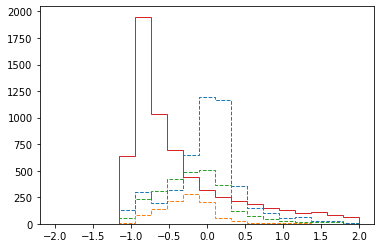

In [26]:
this_nu = slc_opt0_df[slc_opt0_df.nu_index!=-999]
this_co = slc_opt0_df[slc_opt0_df.nu_index==-999]

bins=np.linspace(-2,2,20)
# plt.hist(this_nu.frac_pe,histtype="step",bins=bins,label="nu interactions")
plt.hist([this_nu[this_nu.signal==0].frac_pe,
        #   this_nu[this_nu.signal==1].frac_pe,
          this_nu[this_nu.signal==2].frac_pe,
        #   this_nu[this_nu.signal==3].frac_pe,
          this_nu[this_nu.signal==4].frac_pe,
          ]
         ,histtype="step",bins=bins,
        #  stacked=True,
         linestyle="--")
plt.hist(this_co.frac_pe,histtype="step",bins=bins,label="cosmics")
plt.show()

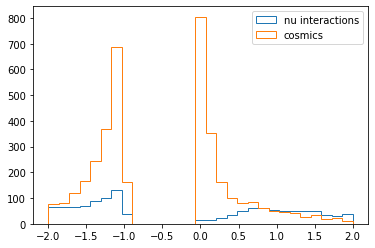

In [28]:
this_nu = slc_opt0_df[(slc_opt0_df.nu_index!=-999) & (abs(slc_opt0_df.slc_vertex_x) > 100) ]
this_co = slc_opt0_df[(slc_opt0_df.nu_index==-999) & (abs(slc_opt0_df.slc_vertex_x) > 100) ]

bins=np.linspace(-2,2,30)
plt.hist(1/this_nu.frac_pe,histtype="step",
        bins=bins,
        label="nu interactions")
plt.hist(1/this_co.frac_pe,histtype="step",
        bins=bins,
        label="cosmics")
# plt.xscale('log')
plt.legend()
plt.show()

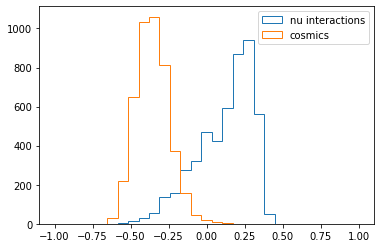

In [29]:
this_nu = slc_opt0_df[(slc_opt0_df.nu_index!=-999) & (abs(slc_opt0_df.slc_vertex_x) < 100) ]
this_co = slc_opt0_df[(slc_opt0_df.nu_index==-999) & (abs(slc_opt0_df.slc_vertex_x) < 100) ]

# bins=np.logspace(-5,0,30)
bins=np.linspace(-1,1,30)
plt.hist(this_nu.slc_crumbs_result_score,histtype="step",bins=bins,label="nu interactions")
plt.hist(this_co.slc_crumbs_result_score,histtype="step",bins=bins,label="cosmics")
# plt.xscale('log')
plt.legend()
plt.show()

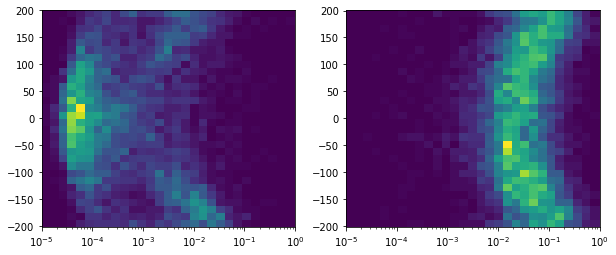

In [30]:
this_nu = slc_opt0_df[slc_opt0_df.nu_index!=-999]
this_co = slc_opt0_df[slc_opt0_df.nu_index==-999]

fig, axes = plt.subplots(1,2,sharex=True,figsize=(10,4))
bins=np.logspace(-5,0,30)
axes[0].hist2d(1/this_nu.score,this_nu.slc_vertex_x,bins=[bins,30])
axes[1].hist2d(1/this_co.score,this_co.slc_vertex_x,bins=[bins,30])
axes[0].set_xscale('log')
# plt.legend()
plt.show()

In [31]:
fail_df = this_nu[(this_nu.score < 200) & (abs(this_nu.slc_vertex_x)>100)]
fail_df

,ntuple,entry,rec.slc__index,rec.slc.reco.pfp__index,slc_is_clear_cosmic,slc_vertex_x,slc_vertex_y,slc_vertex_z,slc_self,slc_tmatch_eff,...,npro,nother,run,subrun,event,tpc,score,hypo_pe,flash_pe,frac_pe
22,0,10,1,0,0,-111.905319,-182.436249,4.238324,49,0.029862,...,5.0,0.0,1,1,11,0,159.433692,3628.586360,133951.241475,-0.972911
39,0,17,0,0,0,-180.848389,-178.681122,179.860916,51,0.937601,...,2.0,1.0,1,1,18,0,20.944922,315967.532737,73392.530275,3.305173
41,0,18,1,0,0,191.875870,131.906738,181.040985,37,0.067709,...,1.0,1.0,1,1,19,1,47.882758,5305.842401,56471.742200,-0.906044
43,0,19,1,0,0,-156.229584,80.061035,325.425415,67,0.917122,...,0.0,1.0,1,1,20,0,156.703921,65036.260811,43093.641900,0.509185
44,0,20,0,0,0,147.254791,-76.867386,187.941299,45,0.821420,...,0.0,1.0,1,1,21,1,127.542568,226232.319377,177335.018675,0.275734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17722,0,9272,3,0,0,-172.061935,-28.630497,397.306244,74,0.100651,...,1.0,4.0,1,151,23,0,44.892646,9495.476289,67399.473700,-0.859116
17724,0,9273,0,0,0,-187.320740,78.740707,405.507477,68,0.914505,...,1.0,1.0,1,151,24,0,87.651052,28507.971634,30715.048475,-0.071857
17733,0,9278,2,0,0,185.845154,134.463043,267.983948,67,0.959773,...,1.0,0.0,1,151,29,1,111.619001,87851.891241,50358.345075,0.744535
17754,0,9288,1,0,0,-160.952042,-111.638756,496.928802,68,0.949521,...,1.0,0.0,1,151,39,0,134.616643,11502.958075,22136.972350,-0.480373


In [32]:
test_df = uproot.open("/sbnd/data/users/lynnt/v09_75_03_02/ana_opt0_cheat.root:opt0finder/flash_match_tree").arrays(['run','subrun','event','tpc','pfpid','score','t0','hypo_pe','flash_pe','hypo_spec','flash_spec'],library="pd",entry_stop=1000)


In [33]:
subrun = 1 
event = 18 
pfpid = 51 
test_df[(test_df.subrun == subrun) & (test_df.event==event) & (test_df.pfpid==pfpid) & (test_df.hypo_spec != test_df.flash_spec)].head(60)

run  subrun  event  tpc  pfpid      score        t0  \
entry subentry                                                        
52    6           1       1     18    0     51  20.944922  0.984272   
      8           1       1     18    0     51  20.944922  0.984272   
      10          1       1     18    0     51  20.944922  0.984272   
      12          1       1     18    0     51  20.944922  0.984272   
      14          1       1     18    0     51  20.944922  0.984272   
      16          1       1     18    0     51  20.944922  0.984272   
      36          1       1     18    0     51  20.944922  0.984272   
      38          1       1     18    0     51  20.944922  0.984272   
      40          1       1     18    0     51  20.944922  0.984272   
      60          1       1     18    0     51  20.944922  0.984272   
      62          1       1     18    0     51  20.944922  0.984272   
      64          1       1     18    0     51  20.944922  0.984272   
      66          1       1     18    0     51  20.944922  0.984272   
      68          1       1     18    0     51  20.944922  0.984272   
      70          1       1     18    0     51  20.944922  0.984272   
      86          1       1     18    0     51  20.944922  0.984272   
      88          1       1     18    0     51  20.944922  0.984272   
      90          1       1     18    0     51  20.944922  0.984272   
      92          1       1     18    0     51  20.944922  0.984272   
      94          1       1     18    0     51  20.944922  0.984272   
      114         1       1     18    0     51  20.944922  0.984272   
      116         1       1     18    0     51  20.944922  0.984272   
      118         1       1     18    0     51  20.944922  0.984272   
      138         1       1     18    0     51  20.944922  0.984272   
      140         1       1     18    0     51  20.944922  0.984272   
      142         1       1     18    0     51  20.944922  0.984272   
      144         1       1     18    0     51  20.944922  0.984272   
      146         1       1     18    0     51  20.944922  0.984272   
      148         1       1     18    0     51  20.944922  0.984272   
      162         1       1     18    0     51  20.944922  0.984272   
      164         1       1     18    0     51  20.944922  0.984272   
      166         1       1     18    0     51  20.944922  0.984272   
      168         1       1     18    0     51  20.944922  0.984272   
      170         1       1     18    0     51  20.944922  0.984272   
      172         1       1     18    0     51  20.944922  0.984272   
      192         1       1     18    0     51  20.944922  0.984272   
      194         1       1     18    0     51  20.944922  0.984272   
      196         1       1     18    0     51  20.944922  0.984272   
      216         1       1     18    0     51  20.944922  0.984272   
      218         1       1     18    0     51  20.944922  0.984272   
      220         1       1     18    0     51  20.944922  0.984272   
      222         1       1     18    0     51  20.944922  0.984272   
      224         1       1     18    0     51  20.944922  0.984272   
      226         1       1     18    0     51  20.944922  0.984272   
      240         1       1     18    0     51  20.944922  0.984272   
      242         1       1     18    0     51  20.944922  0.984272   
      244         1       1     18    0     51  20.944922  0.984272   
      246         1       1     18    0     51  20.944922  0.984272   
      248         1       1     18    0     51  20.944922  0.984272   
      250         1       1     18    0     51  20.944922  0.984272   
      270         1       1     18    0     51  20.944922  0.984272   
      272         1       1     18    0     51  20.944922  0.984272   
      274         1       1     18    0     51  20.944922  0.984272   
      294         1       1     18    0     51  20.944922  0.984272   
      296         1       1     18    0 

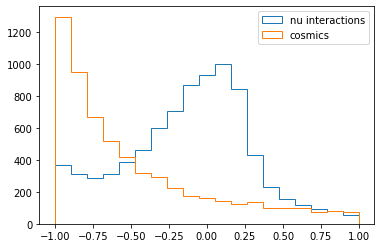

In [34]:
this_nu = slc_opt0_df[slc_opt0_df.nu_index!=-999]
this_co = slc_opt0_df[slc_opt0_df.nu_index==-999]

bins=np.linspace(-1,1,20)
plt.hist(this_nu.frac_pe,histtype="step",bins=bins,label="nu interactions")
plt.hist(this_co.frac_pe,histtype="step",bins=bins,label="cosmics")
# plt.xscale('log')
plt.legend()
plt.show()